In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from keras.models import Sequential
from keras.layers import Dense, LSTM
from scipy.stats import norm

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from keras.callbacks import EarlyStopping

In [2]:
tweet_vaderized = pd.read_excel('data/sentitweet610.xlsx')
reddit_vaderized = pd.read_excel('data/sentireddit610.xlsx')
startDate = pd.to_datetime('20160601')
endDate = pd.to_datetime('20161001')
i_hour = pd.date_range(start=startDate, end=endDate,freq='H')

tweet_senti = tweet_vaderized.resample('H', on='dtime').mean().reindex(i_hour).fillna(0).loc[:,['vader_compound']]
redditmidsum = reddit_vaderized.resample('H', on='time').sum().reindex(i_hour).fillna(0)
redditmidsum['sentivader'] = (redditmidsum.vaderscore / redditmidsum.scoren).fillna(0)
reddit_senti =  redditmidsum.loc[:,['sentivader']]

senti = pd.concat([tweet_senti, reddit_senti], axis=1)
senti.columns = ['tweet_senti','reddit_senti']

senti['tweet_count'] = (tweet_vaderized.resample('H', on='dtime').count().loc[:,['vader_compound']])
senti['reddit_count'] = (reddit_vaderized.resample('H', on='time').sum().loc[:,['scoren']])

senti = senti.fillna(0)

senti['tweet_logcount'] = np.log(senti['tweet_count']+1)
senti['reddit_logcount'] = np.log(senti['reddit_count']+1)

senti.to_excel('data/senti610day.xlsx', index=True)

In [3]:
dates = senti.index

# Normalize Data
scaler_senti = MinMaxScaler(feature_range=(0,1))
senti['senti_scaled'] = scaler_senti.fit_transform(senti.loc[:,['tweet_senti']].values)
# scaler_count = MinMaxScaler(feature_range=(0,1)) 
# senti['count_scaled'] = scaler_count.fit_transform(senti.loc[:,['tweet_logcount']].values)

data = senti.loc[:,['senti_scaled']] #,'count_scaled']]
data.columns = ['senti'] #,'count']

# create variable shifted senti to be predicted
data['senti1'] = data['senti'].shift().fillna(0)

n_vars = data.shape[1]-1
seqlen = 24
values = data.values
valuesX, valuesy = values[:, :n_vars], values[:, n_vars:]

In [4]:
def generate_data(x, y, seqlen):
    data = []
    label = []    
    #reshape to the input from of LSTM, [samples,timesteps,features]    
    for i in range(len(x) - seqlen):
        data.append(x[i: i+seqlen, :])
        #print(x[i: i+ts, :])
        label.append(y[i+seqlen])
    return np.array(data, dtype=np.float64), np.array(label, dtype=np.float64)

def build_lstm(n_neurons, seqlen, r_dropout):
    model = Sequential()
    model.add(LSTM(n_neurons, 
                   input_shape=(seqlen, n_vars), #seqlen,  X.shape[1]
                   dropout=r_dropout))
    model.add(Dense(1))
    model.compile(loss = 'mse', optimizer = 'Adam')   
    return model

def eval_lstm(model, X_test, y_test):
    yhat = model.predict(X_test)
    inv_yhat = scaler_senti.inverse_transform(yhat)
    inv_y = scaler_senti.inverse_transform(y_test)    
    rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat)) 
    return rmse

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=20,  
    mode='auto'
)

def train_lstm(n_neurons, r_dropout, n_batch, seqlen):     
    model = build_lstm(n_neurons, seqlen, r_dropout)   
    X,y = generate_data(valuesX, valuesy, seqlen)    
    tscv = TimeSeriesSplit()
    errors = []
    epoch_runs = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]  
        # 这里跑五次！
        history = model.fit(X_train, y_train, epochs=n_epoch, batch_size=n_batch, 
                            validation_data=(X_test, y_test), verbose=0, shuffle=False, callbacks = [early_stopping])
        
        epoch_run = len(history.history['loss'])
        rmse = eval_lstm(model, X_test, y_test)
        print(epoch_run, rmse)
        errors.append(rmse)
        epoch_runs.append(epoch_run) 
    return errors, epoch_runs  

In [5]:
n_epoch = 1000

best_score = 10000
best_para = {}
params = []

# for n_neurons in [4,8,16,32]:
#     for n_batch in [4,16,32,64]:          
#         for r_dropout in [0.05,0.1]:
#             for seqlen in [4,8,16,24]:
#                 errors, epoch_runs = train_lstm(n_neurons, r_dropout, n_batch, seqlen)
#                 rmse = np.average(errors)
#                 epoch_run = np.average(epoch_runs)
#                 param = {'rmse': rmse, 'epoch_run': epoch_run, 'errors': errors, 'epoch_runs':epoch_runs,
#                          'n_neurons':n_neurons, 'r_dropout':r_dropout, 'n_batch':n_batch, 'seqlen': seqlen }
#                 params.append(param)
#                 print(param)   
#                 if rmse < best_score:
#                     best_score = rmse
#                     best_para = param
#                     print('New best model!')
# pd.DataFrame(params).sort_values('rmse')

In [6]:
best_para = {'rmse': 0.047771815160401375, 'epoch_run': 54.8, 'errors': [0.07300034503523514, 0.04042488215004974, 0.044445521495794775, 0.0443045696259033, 0.036683757495023894], 'epoch_runs': [60, 82, 28, 33, 71], 'n_neurons': 32, 'r_dropout': 0.05, 'n_batch': 4, 'seqlen': 4}
print(best_para)

{'rmse': 0.047771815160401375, 'epoch_run': 54.8, 'errors': [0.07300034503523514, 0.04042488215004974, 0.044445521495794775, 0.0443045696259033, 0.036683757495023894], 'epoch_runs': [60, 82, 28, 33, 71], 'n_neurons': 32, 'r_dropout': 0.05, 'n_batch': 4, 'seqlen': 4}


In [7]:
n_neurons = 16 #best_para['n_neurons']
r_dropout = 0.05 #best_para['r_dropout']
n_batch = 4 #best_para['n_batch']
seqlen = 4 #best_para['seqlen']
n_epoch = 100

X,y = generate_data(valuesX, valuesy, seqlen)
split_train = math.floor(len(X) * 0.8)
X_train, X_test = X[:split_train], X[split_train:]
y_train, y_test = y[:split_train], y[split_train:]  

In [8]:
# rmsess = []
# params = []

# for seqlen in [4,8,16,24]:
#     for n_neurons in [4,8,16,32]:
#         X,y = generate_data(valuesX, valuesy, seqlen)    
#         X_train, X_test = X[:split_train], X[split_train:]
#         y_train, y_test = y[:split_train], y[split_train:]  
#         rmses = []
#         for i in range(6):
#             best_model = build_lstm(n_neurons, seqlen, r_dropout) 
#             history = best_model.fit(X_train, y_train, 
#                               epochs = n_epoch, batch_size = n_batch, 
#                               validation_data = (X_test, y_test), 
#                               verbose = 0, shuffle=False)
#             rmse = eval_lstm(best_model, X_test, y_test)
#             print(rmse)
#             rmses.append(rmse)
#         rmsess.append(rmses)
#         param = {'rmse': rmses, 'n_neurons':n_neurons, 'seqlen': seqlen }
#         params.append(param)

# print(rmses)
# print('average rmse',np.average(rmses[:4]))
# print('average rmse',np.average(rmses[1:4]))

In [9]:
# for history in historys:
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title('model train vs validation loss')
#     plt.ylabel('loss')
#     plt.xlabel('epoch')
#     plt.legend(['train','validation'],loc='upper right')
#     plt.show()

0.03794503453537597


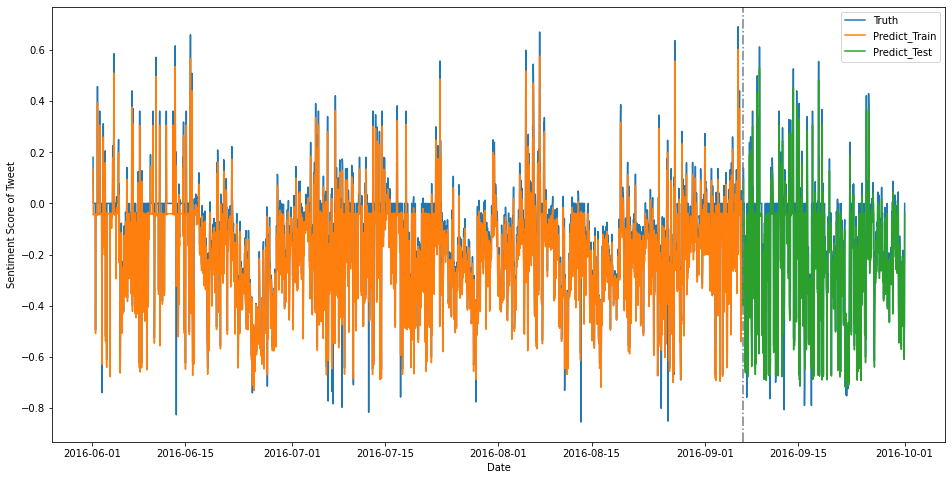

In [10]:
# best_model = models[2]
best_model = build_lstm(n_neurons, seqlen, r_dropout) 
history = best_model.fit(X_train, y_train, 
                  epochs = n_epoch, batch_size = n_batch, 
                  validation_data = (X_test, y_test), 
                  verbose = 0, shuffle=False)

yhat = best_model.predict(X_test)
inv_yhat = scaler_senti.inverse_transform(yhat)
inv_y = scaler_senti.inverse_transform(y_test)    
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat)) 
print(rmse)

fitted, preds = best_model.predict(X_train), best_model.predict(X_test)
inv_fitted, inv_preds = scaler_senti.inverse_transform(fitted), scaler_senti.inverse_transform(preds)
inv_y  = scaler_senti.inverse_transform(y)

plt.figure(figsize=(16,8)) 
plt.plot(dates[seqlen:],inv_y,label = 'Truth')
plt.plot(dates[seqlen:seqlen+split_train],inv_fitted, label = 'Predict_Train')
plt.plot(dates[seqlen+split_train:],inv_preds, label = 'Predict_Test')
plt.axvline(x=dates[seqlen+split_train], color='slategray', linestyle='-.')
plt.xlabel("Date")
plt.ylabel("Sentiment Score of Tweet")
plt.legend()
plt.show()

# OI

In [11]:
reddit_data = senti['reddit_senti'].copy()
tweet_data = senti['tweet_senti'].copy()
kalmanData = pd.concat([reddit_data, tweet_data],axis=1)
kalmanData.columns = ['reddit', 'tweet']

reddit_hourvar_mean = reddit_vaderized.resample('H', on='time').var().vadern.reindex(i_hour).mean() #reddit var per day.mean()
reddit_var = kalmanData['reddit'].to_numpy(dtype=float).var()
tweet_var = kalmanData['tweet'].to_numpy(dtype=float).var()
print(reddit_var,tweet_var,reddit_hourvar_mean)

H=1
R_r = reddit_hourvar_mean
P0_r = tweet_var
K_t = P0_r * H / (H * P0_r * H + R_r)
print("K_r with Twitter as P0", K_t)

0.06726473971947694 0.048915568843057415 0.2684919913595351
K_r with Twitter as P0 0.15410965262401422


In [12]:
P0_r = reddit_var
K_r = P0_r * H / (H * P0_r * H + R_r)
print("K_r with Reddit as P0", K_r)

K_r with Reddit as P0 0.20033772518367723


In [13]:
predx = 72 
length = seqlen
it = np.arange(seqlen, len(kalmanData) - predx)

In [63]:
best_model = build_lstm(n_neurons, seqlen, r_dropout) 
history = best_model.fit(X[:-predx], y[:-predx], 
                  epochs = n_epoch, batch_size = n_batch, 
                  verbose = 0, shuffle=False)

In [31]:
def show_result(da_r, pred_r, part):    
#     plt.figure(figsize=(16,8)) 
#     plt.plot(kalmanData['tweet'], linestyle='-', label='Tweets', alpha=0.7)
#     plt.plot(kalmanData['reddit'], linestyle='-', label='Reddits', alpha=0.7) 
#     plt.plot(kalmanData[da_r], linestyle='--', label='Assimilated', color='black',alpha=0.5) 
#     plt.xlabel("Date")
#     plt.ylabel("Sentiment Score")
#     plt.legend()
#     plt.ylim([-1, 1])
#     plt.show()
    
#     plt.figure(figsize=(16,8)) 
#     plt.plot(kalmanData['tweet'][-part:], linestyle='-', label='Tweets', alpha=0.7)
#     plt.plot(kalmanData['reddit'][-part:], linestyle='-', label='Reddits', alpha=0.7) 
#     plt.plot(kalmanData[da_r][-part:], linestyle='--', label='Assimilated', color='black',alpha=0.5) 
#     plt.fill_between(dates[-predx:], -1, 1,facecolor='gainsboro', interpolate=True)
#     plt.xlabel("Date")
#     plt.ylabel("Sentiment Score")
#     plt.legend()
#     plt.ylim([-1, 1])
#     plt.show()
    
    ### VALIDATION ###
    plt.figure(figsize=(5, 3))
    # 1) see if residuals are zero mean gaussian (MAKE SURE TO SET DELAY TO ZERO!)
    res = kalmanData[pred_r][length:-predx] - kalmanData['reddit'][length:-predx].to_numpy()  # all Reddits
    (mu, sigma) = norm.fit(res)
    # the residual error plot (histogram + normal distr)
    n, bins, patches = plt.hist(res, density=True, facecolor='C0', alpha=0.75)
    y = norm.pdf(bins, loc=mu, scale=sigma)
    plt.plot(bins, y, 'r--', linewidth=2)
    plt.title("Wildfire Sentiment with $\mu=" + str(round(mu, 4)) + "$ and $\sigma =" + str(round(sigma, 4)) + "$")
    plt.show()

    # 2) MSE
    X = kalmanData[da_r][length:-predx].to_numpy()
    Y_tweet = kalmanData['tweet'][length:-predx].to_numpy()
    mse_t = sum((X - Y_tweet) ** 2) / X.size
    print("mse for tweet", mse_t)
    Y_reddit = kalmanData['reddit'][length:-predx].to_numpy() 
    mse_r = sum((X - Y_reddit) ** 2) / X.size
    print("mse for reddit", mse_r)

In [18]:
def OI_LSTM_no(da_r, pred_r, K_r):      
    kalmanData[da_r] = np.nan
    kalmanData[pred_r] = np.nan  
    seq = X[0:1]

    for i in it:  
        xf = best_model.predict(seq)  # predict   
        xf = scaler_senti.inverse_transform(xf) 
        kalmanData[pred_r].iloc[i] = xf[0][0]
        xa = xf + K_r * (kalmanData['reddit'].iloc[i] - H * xf)  # update 
        kalmanData[da_r].iloc[i] = xa       
        # update sequence
        xa = scaler_senti.transform(xa)
        seq = seq.flatten()
        seq = np.append(seq, xa)
        seq = seq[1:]
        seq = np.reshape(seq, (1, seqlen, 1))
        
    # predict x hours ahead
    for i in range(predx): 
        xf = best_model.predict(seq)  # predict   
        
        seq = seq.flatten()
        seq = np.append(seq, xf[0][0])
        seq = seq[1:]
        seq = np.reshape(seq, (1, seqlen, 1))
        
        xf = scaler_senti.inverse_transform(xf) 
        kalmanData[pred_r].iloc[-predx+i] = xf[0][0]
        kalmanData[da_r].iloc[-predx+i] = xf[0][0]

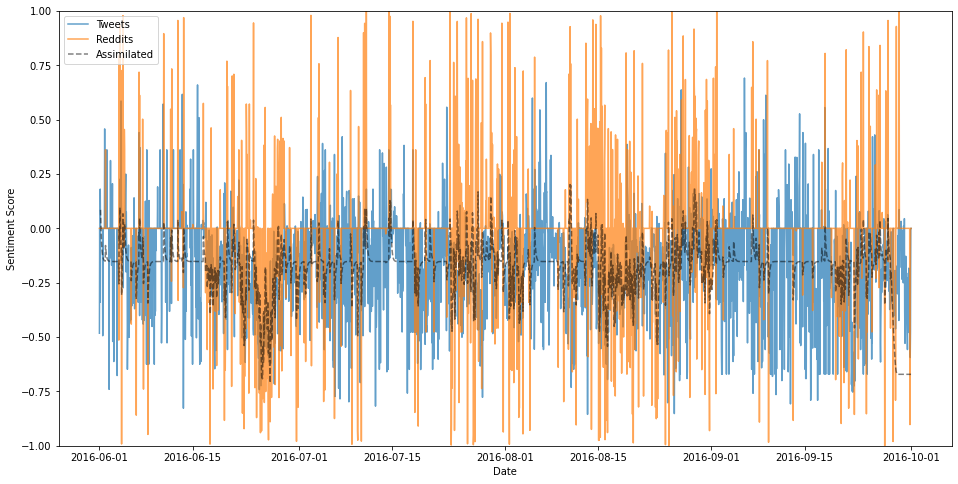

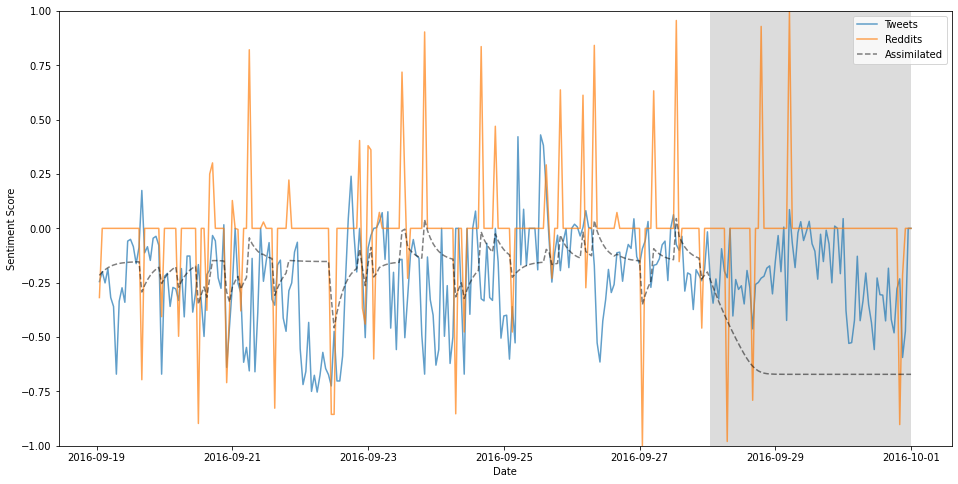

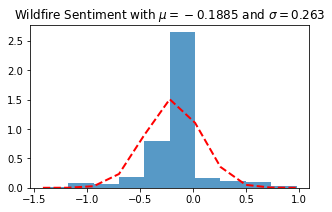

mse for tweet 0.05118605145604957
mse for reddit 0.06695399703938146


In [19]:
OI_LSTM_no('da_oi_lstm_r', 'pred_oi_lstm_r', K_r)
show_result('da_oi_lstm_r', 'pred_oi_lstm_r', 288)

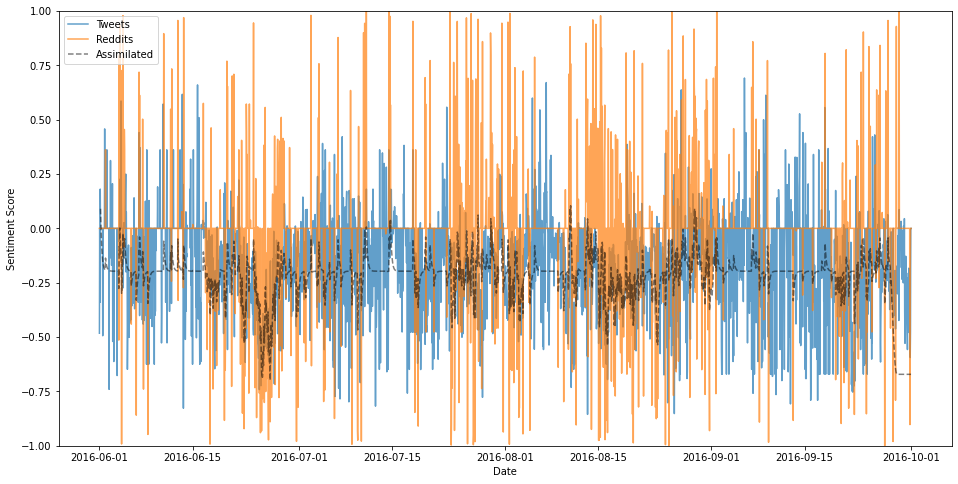

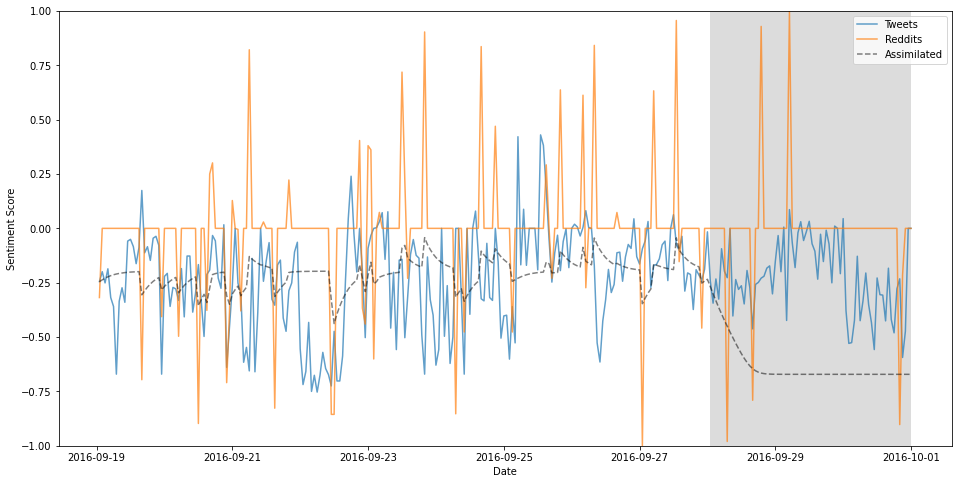

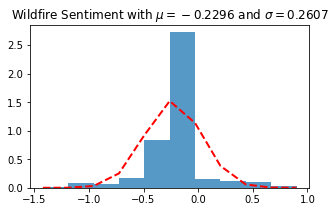

mse for tweet 0.051284343223080064
mse for reddit 0.08637621254885898


In [20]:
OI_LSTM_no('da_oi_lstm_t', 'pred_oi_lstm_t', K_t)
show_result('da_oi_lstm_t', 'pred_oi_lstm_t', 288)

# Enkf

In [23]:
P0_r = reddit_var
n_points=1000
Q_r = R_r

In [39]:
def enkf_lstm(da_r, pred_r, Q_r, R_r, k_r):
    P0_r = reddit_var
    x0 = 0.5
    H = 1
    
    kalmanData[da_r], kalmanData[pred_r], kalmanData[k_r]= np.nan, np.nan, np.nan 
    
    seq = X[0:1]
    sigmas_seq = np.empty((n_points,length,1))
    xf = np.empty(n_points)
    sigmas = np.random.normal(0, P0_r, size=(n_points, 1))  # draw from distribution, normally P0_r
    for i in range(n_points):
        sigmas_seq[i] = seq+sigmas[i]
    sigmas_seq = np.reshape(sigmas_seq,(n_points, length,1))

#     Ks = []
    # assimilation scheme
    for j in it:
        #predict
        xf = best_model.predict(sigmas_seq)
        xf = scaler_senti.inverse_transform(xf)
        xf += np.random.normal(0, Q_r, size=(n_points,1)) # should be x and p0?
        xmean = np.mean(xf)
        kalmanData[pred_r].iloc[j] = xmean #preds.append(xmean)    

        #update
        xf_z = H*xf
        zmean = np.mean(xf_z)
        Pzz = np.var(xf_z,ddof=1)+R_r
        Pxz = 0
        for i in range(n_points):
            Pxz += (xf[i]-xmean)*(xf_z[i]-zmean)
        Pxz/=n_points-1

        K_r = Pxz/Pzz
#         Ks.append(K_r)
        kalmanData[k_r].iloc[j] = K_r 
        v_r = np.random.normal(0,R_r,n_points) #should be R_r 

        y = kalmanData['reddit'].iloc[j]

        for i in range(n_points):
            xf[i] += K_r*(y+v_r[i]-xf_z[i])

        x0 = np.mean(xf)
        P0_r = P0_r - K_r*Pzz*K_r
        kalmanData[da_r].iloc[j] = x0    #kalmanData['result_tweet'].iloc[j] = x0
        
        #create new sequence
        xf_scaled = scaler_senti.transform(np.reshape(xf,(n_points,-1)))
        for i in range(n_points):
            seq = np.append(sigmas_seq[i], xf_scaled[i])
            sigmas_seq[i] = np.reshape(seq[1:],(length,1))

    sigmas_seq = np.reshape(sigmas_seq,(n_points,length,1))

    for j in range(predx):
        # predict
        xf = best_model.predict(sigmas_seq)
        xf = scaler_senti.inverse_transform(xf)
        
        xf += np.random.normal(0, Q_r, size=(n_points, 1))  # should be x and p0?
        x0 = np.mean(xf)
        
        kalmanData[pred_r].iloc[-predx+j] = x0 #preds_extra_tweet.append(x0)
        kalmanData[da_r].iloc[-predx+j] = x0
        
        #print(j,x0)
        
        xf_scaled = scaler_senti.transform(np.reshape(xf,(n_points,-1)))
        
        # create new sequence
        for i in range(n_points):
            seq = np.append(sigmas_seq[i], xf_scaled[i])
            sigmas_seq[i] = np.reshape(seq[1:], (length, 1))

        sigmas_seq = np.reshape(sigmas_seq, (n_points, length, 1))
    show_result(da_r, pred_r, 288)

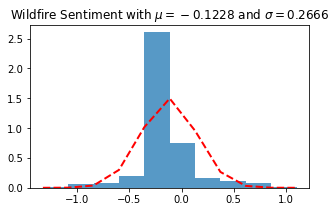

mse for tweet 0.05979010214157662
mse for reddit 0.04013127245999859


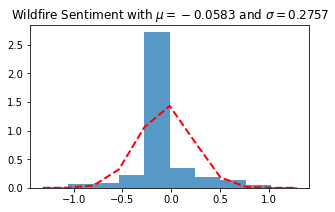

mse for tweet 0.08529750436299369
mse for reddit 0.01448704363563709


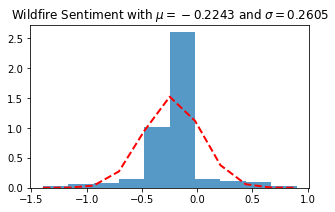

mse for tweet 0.05082996712694326
mse for reddit 0.08388053645255024


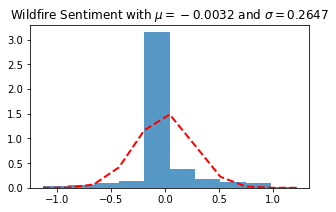

mse for tweet 0.0833194183585194
mse for reddit 0.021760240205673777


In [40]:
enkf_lstm('da_ekf_lstm', 'pred_ekf_lstm', Q_r, R_r,'k_lstm')
enkf_lstm('da_ekf_lstm1', 'pred_ekf_lstm1', 2*R_r, R_r,'k_lstm1')
enkf_lstm('da_ekf_lstm2', 'pred_ekf_lstm2', 0.5*R_r, R_r,'k_lstm2')
enkf_lstm('da_ekf_lstm3', 'pred_ekf_lstm3', 4*R_r, 4*R_r,'k_lstm3')

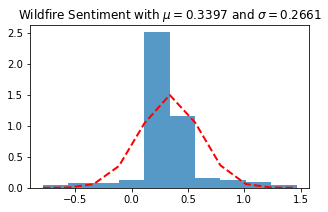

mse for tweet 0.1549962551107059
mse for reddit 0.03096620889708252


In [56]:
enkf_lstm('da_ekf_lstm4', 'pred_ekf_lstm4', 4*R_r, 4*R_r,'k_lstm4')

In [62]:
kalmanData['k_lstm'].mean(),kalmanData['k_lstm1'].mean(),kalmanData['k_lstm2'].mean(),kalmanData['k_lstm3'].mean(),kalmanData['k_lstm4'].mean()

(0.31866262872992923,
 0.5729679101774494,
 0.15845759490310957,
 0.4412385622869238,
 0.5927877228509908)

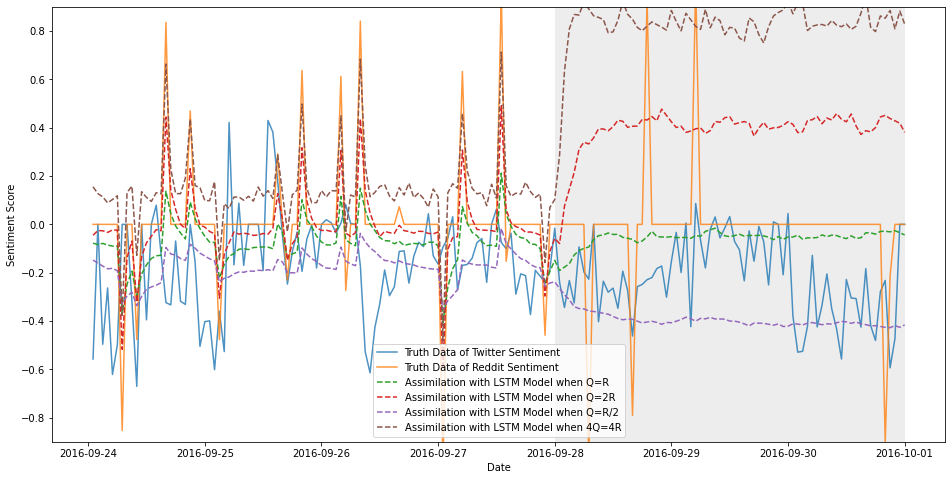

In [58]:
part=168
plt.figure(figsize=(16,8)) #
plt.plot(kalmanData['tweet'][-part:],linestyle='-',alpha=0.8,label = 'Truth Data of Twitter Sentiment')
plt.plot(kalmanData['reddit'][-part:],linestyle='-',alpha=0.8,label = 'Truth Data of Reddit Sentiment')
plt.plot(kalmanData['da_ekf_lstm'][-part:],linestyle='--',label = 'Assimilation with LSTM Model when Q=R')
plt.plot(kalmanData['da_ekf_lstm1'][-part:],linestyle='--',label = 'Assimilation with LSTM Model when Q=2R')
plt.plot(kalmanData['da_ekf_lstm2'][-part:],linestyle='--',label = 'Assimilation with LSTM Model when Q=R/2')
# plt.plot(kalmanData['da_ekf_lstm3'][-part:],linestyle='--',label = 'Assimilation with LSTM Model when 2Q=2R')
plt.plot(kalmanData['da_ekf_lstm4'][-part:],linestyle='--',label = 'Assimilation with LSTM Model when 4Q=4R')

plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.legend()
plt.fill_between(dates[-73:], -1, 1,facecolor='gainsboro', alpha=0.5,interpolate=True)
plt.ylim([-0.9, 0.9])
plt.show()

In [60]:
k=kalmanData[['k_lstm','k_lstm1','k_lstm2','k_lstm4']]

In [61]:
kalmanData.to_excel('lstmno.xlsx', index=True)